In [1]:
import pandas as pd
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from typing import Any
from funcoes import aplicar_imputacao_treino,pipeline_modelagem,plot_comparacao_roc,plot_comparacao_prc,aplicar_imputacao_teste,escolher_estrategia_imputacao


In [2]:
treino_selecionado = pd.read_csv("treino_selecionada.csv")

In [3]:
# A base -> treino_selecionado precisa ser dividida em train, test (desenvolvimento e validação oos)
# 20% da base é o test, que vai servir de base para avaliar o modelo no OOS
train, test = train_test_split(treino_selecionado, test_size=0.2, stratify=treino_selecionado['y'], random_state=42)

In [4]:
train.shape, test.shape

((6568, 37), (1643, 37))

In [5]:
# Por padrão o Pycaret não permite a imputação dinâmica de missings, então vamos tratar os missings com nossa função e depois aplicar no teste OOS do pycaret
# Assim o setup não vai precisar tratar os missings, pois o dataset não terá missings para tratar
# Vamos salvar esse pipeline e utilizar no código de escoragem

In [6]:
regra_imputacao = escolher_estrategia_imputacao(train)
train, regra_imputacao, dict_mediana, dict_media = aplicar_imputacao_treino(train,regra_imputacao)
test = aplicar_imputacao_teste(test,regra_imputacao, dict_mediana, dict_media)

In [7]:
train.shape, test.shape

((6568, 37), (1643, 37))

In [8]:
a,train, test, tuned_lightgbm, tuned_lr,train_lightgbm_escorado, \
test_lightgbm_escorado,train_regressao_escorado, test_regressao_escorado = pipeline_modelagem(train, test, id_col='id', safra_col='safra', target_col='y')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7809,0.7856,0.3892,0.7008,0.4985,0.3735,0.4007,0.1400
lightgbm,Light Gradient Boosting Machine,0.7796,0.7806,0.4284,0.6723,0.5213,0.3878,0.4053,0.2700


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7719,0.7719,0.4595,0.6296,0.5312,0.3853,0.3937
1,0.7833,0.7987,0.4392,0.6771,0.5328,0.3999,0.4158
2,0.7814,0.7913,0.5034,0.6466,0.5660,0.4229,0.4288
3,0.8080,0.7977,0.5302,0.7182,0.6100,0.4865,0.4963
4,0.7714,0.7412,0.3581,0.6795,0.4690,0.3407,0.3691
5,0.7790,0.7833,0.3784,0.7000,0.4912,0.3658,0.3940
6,0.7752,0.7758,0.4189,0.6596,0.5124,0.3757,0.3920
7,0.7752,0.7845,0.3986,0.6705,0.5000,0.3669,0.3875
8,0.7714,0.7570,0.3986,0.6556,0.4958,0.3592,0.3777


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7909,0.7802,0.3784,0.7568,0.5045,0.3901,0.4278
1,0.7890,0.8175,0.3649,0.7606,0.4932,0.3800,0.4210
2,0.7738,0.7902,0.4228,0.6562,0.5143,0.3757,0.3911
3,0.7852,0.8162,0.3893,0.7250,0.5066,0.3848,0.4152
4,0.7886,0.7643,0.3378,0.7937,0.4739,0.3674,0.4200
5,0.7657,0.7779,0.2973,0.6984,0.4171,0.2991,0.3418
6,0.7752,0.7964,0.3378,0.7143,0.4587,0.3391,0.3769
7,0.7810,0.8087,0.3378,0.7463,0.4651,0.3511,0.3947
8,0.7752,0.7829,0.3514,0.7027,0.4685,0.3455,0.3788


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7605,0.7492,0.3446,0.6375,0.4474,0.3114,0.3354
1,0.7947,0.8218,0.4459,0.7174,0.5500,0.4262,0.4464
2,0.7871,0.7965,0.4765,0.6762,0.5591,0.4242,0.4355
3,0.8080,0.8154,0.4765,0.7553,0.5844,0.4677,0.4887
4,0.7771,0.7587,0.3446,0.7183,0.4658,0.3463,0.3836
5,0.7790,0.7809,0.3649,0.7105,0.4821,0.3596,0.3919
6,0.7752,0.7879,0.3514,0.7027,0.4685,0.3455,0.3788
7,0.7676,0.7785,0.3243,0.6857,0.4404,0.3167,0.3520
8,0.7848,0.7877,0.4122,0.7011,0.5191,0.3923,0.4153


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7681,0.7492,0.3649,0.6585,0.4696,0.3364,0.3605
1,0.7947,0.8223,0.4392,0.7222,0.5462,0.4235,0.4454
2,0.7833,0.7956,0.4497,0.6768,0.5403,0.4060,0.4205
3,0.8080,0.8140,0.4698,0.7609,0.5809,0.4653,0.4880
4,0.7790,0.7616,0.3514,0.7222,0.4727,0.3534,0.3902
5,0.7790,0.7823,0.3581,0.7162,0.4775,0.3565,0.3910
6,0.7771,0.7904,0.3581,0.7067,0.4753,0.3526,0.3854
7,0.7695,0.7784,0.3311,0.6901,0.4475,0.3239,0.3588
8,0.7829,0.7866,0.4054,0.6977,0.5128,0.3855,0.4090


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.7805,0.7928,0.3555,0.7300,0.4767,0.3584,0.3962,0.0310
1,Logistic Regression,0.7815,0.7857,0.3865,0.7056,0.4979,0.3738,0.4020,0.0080



🏆 **Modelo Vencedor:** LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.05, max_depth=3,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=10, objective=None,
               random_state=42, reg_alpha=1, reg_lambda=0.5, subsample=0.6,
               subsample_for_bin=200000, subsample_freq=0)
✅ Regressão Logística escolhida com AUC: 0.7857


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7926,0.8277,0.3805,0.7671,0.5087,0.3956,0.4347


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7766,0.7705,0.3456,0.7143,0.4658,0.3455,0.3820


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7820,0.7939,0.3880,0.7070,0.5010,0.3763,0.4041


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7772,0.7788,0.3672,0.6996,0.4816,0.3568,0.3869


base escorada pycaret
        id   safra  VAR_1  VAR_72       VAR_53       VAR_65   VAR_6  \
481    601  201409   16.0    36.0  1565.920044    91.800003   189.0   
3320  4320  201409   82.0    83.0  1928.099976   619.340027   339.0   
6684  8725  201406  112.0    24.0   500.000000   252.800003   175.0   
6873  8977  201402    0.0    43.0  2000.000000  6632.040039  3069.0   
2729  3547  201402   20.0    59.0   600.000000   323.570007   438.0   
...    ...     ...    ...     ...          ...          ...     ...   
2725  3540  201405   46.0    45.0   570.000000   308.260010  1309.0   
2258  2939  201409   21.0    77.0  1565.920044    15.850000    77.0   
2865  3729  201405   26.0   212.0  6700.000000   354.630005   772.0   
3701  4807  201402   29.0   -53.0  1000.000000  1921.089966   281.0   
7576  9921  201405    0.0   -75.0  1000.000000  6150.020020  3318.0   

           VAR_17       VAR_30  VAR_57  ...  VAR_44  VAR_25    VAR_60  VAR_2  \
481    800.000000   800.000000      32  ...  

In [9]:
a.head(2)

,id,safra,VAR_1,VAR_72,VAR_53,VAR_65,VAR_6,VAR_17,VAR_30,VAR_57,...,VAR_44,VAR_25,VAR_60,VAR_2,VAR_28,VAR_19,y,prediction_label,prediction_score_0,prediction_score_1
481,601,201409,16.0,36.0,1565.920044,91.800003,189.0,800.000000,800.000000,32,...,0.0,0.0,-0.354108,0.0,0.0,0.0,1,0,0.6113,0.3887
3320,4320,201409,82.0,83.0,1928.099976,619.340027,339.0,4892.149902,2964.050049,47,...,0.0,0.0,0.079926,0.0,0.0,0.0,1,1,0.3773,0.6227


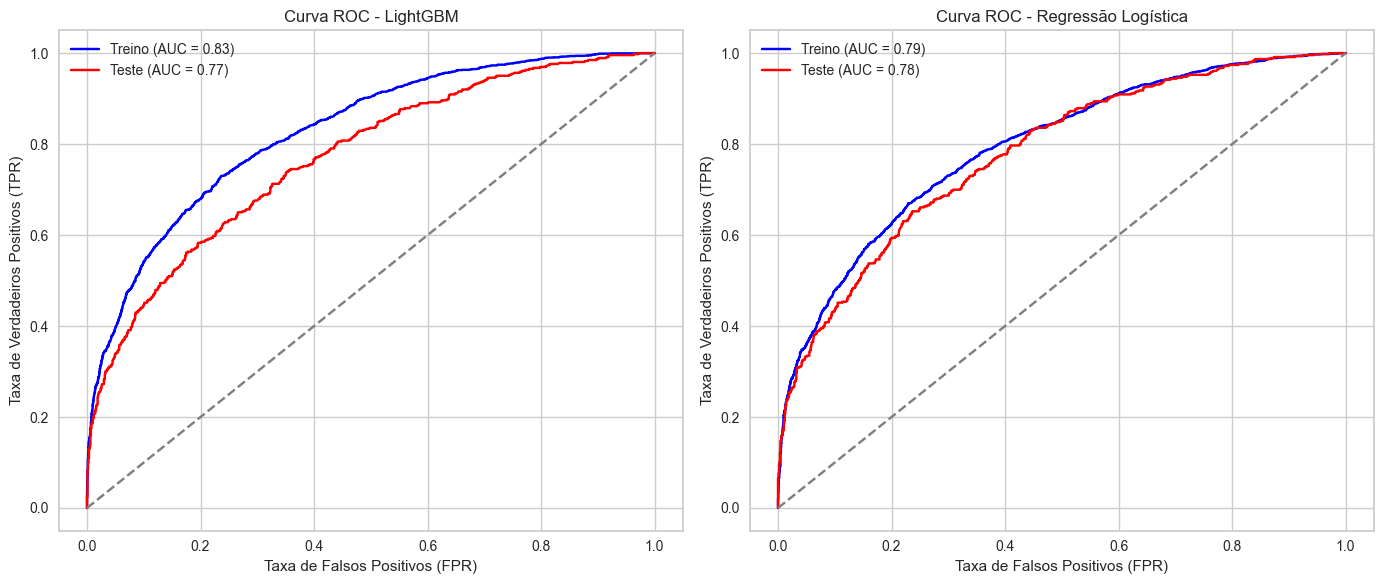

In [14]:
plot_comparacao_roc(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado
)

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_decile_chart(df, score_col, response_col):
    """
    Plota um gráfico de decil com base em uma pontuação de modelo e uma variável de resposta.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo os dados.
    score_col (str): Nome da coluna contendo a pontuação.
    response_col (str): Nome da coluna contendo a resposta binária (0 ou 1).
    """

    # Criando os decis com base na pontuação
    df['decile'] = pd.qcut(df[score_col], q=10, labels=False, duplicates='drop') + 1

    # Calculando a taxa de resposta por decil e os valores mínimo e máximo de score
    decile_stats = df.groupby('decile').agg(
        total=('decile', 'count'),
        events=(response_col, 'sum'),
        min_score=(score_col, 'min'),
        max_score=(score_col, 'max')
    ).reset_index()

    decile_stats['response_rate'] = decile_stats['events'] / decile_stats['total']

    # Ordenando os decis em ordem decrescente de score
    decile_stats = decile_stats.sort_values(by='decile', ascending=False)

    # Criando o gráfico
    plt.figure(figsize=(10, 6))
    plt.bar(decile_stats['decile'], decile_stats['response_rate'], color='blue', alpha=0.7)
    plt.xlabel('Decil')
    plt.ylabel('Taxa de Maus')
    plt.title('Taxa de Maus por Decil')
    plt.xticks(decile_stats['decile'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Exibir gráfico
    plt.show()

    return decile_stats

# Exemplo de uso
# df = pd.DataFrame({'score': np.random.rand(1000), 'response': np.random.randint(0, 2, 1000)})
# plot_decile_chart(df, 'score', 'response')



In [16]:
train_lightgbm_escorado['score_1'].max()

0.9336

In [17]:
train_lightgbm_escorado['score_0'].max()

0.9778

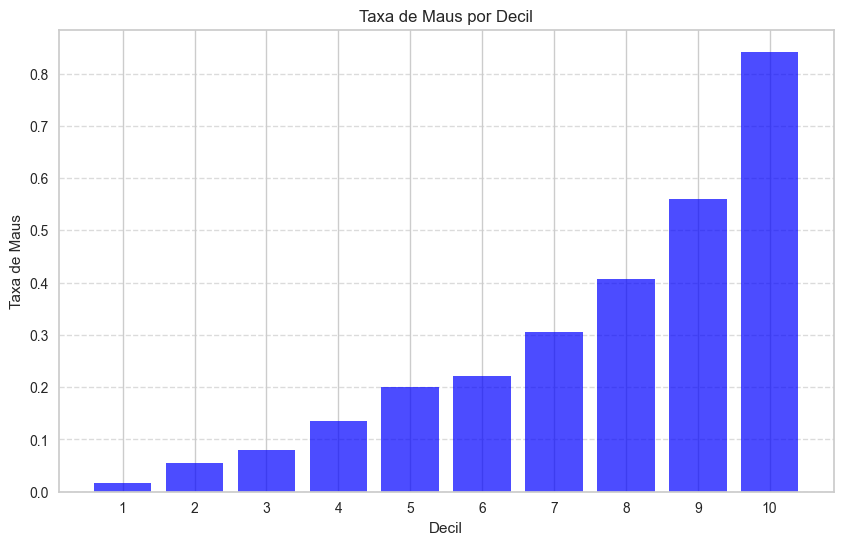

In [18]:

tabela = plot_decile_chart(train_lightgbm_escorado, 'score_1', 'y')

In [16]:
tabela

,decile,total,events,min_score,max_score,response_rate
9,10,657,20,0.9202,0.9778,0.030441
8,9,657,81,0.8871,0.9201,0.123288
7,8,655,109,0.8542,0.8870,0.166412
6,7,658,137,0.8216,0.8541,0.208207
5,6,653,176,0.7886,0.8215,0.269525
4,5,660,156,0.7550,0.7883,0.236364
3,4,657,212,0.7107,0.7549,0.322679
2,3,656,270,0.6555,0.7106,0.411585
1,2,658,319,0.5891,0.6550,0.484802
0,1,657,373,0.5006,0.5890,0.567732


In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_prc_curve(y_true, y_scores, title="Precision-Recall Curve", show_ap=True):
    """
    Plota a Precision-Recall Curve (PRC).
    
    Parâmetros:
    - y_true: array-like, valores reais das classes (0 ou 1).
    - y_scores: array-like, probabilidades preditas pelo modelo.
    - title: str, título do gráfico (padrão: "Precision-Recall Curve").
    - show_ap: bool, se True, exibe a média de precisão no gráfico.
    
    Retorno:
    - None (exibe o gráfico).
    """
    # Calcula Precisão, Recall e limiares
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    
    # Calcula o Average Precision Score
    avg_precision = average_precision_score(y_true, y_scores) if show_ap else None
    
    # Plota a PRC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'AP = {avg_precision:.3f}' if show_ap else "PR Curve")
    
    # Formatação do gráfico
    plt.xlabel("Recall")
    plt.ylabel("Precision")


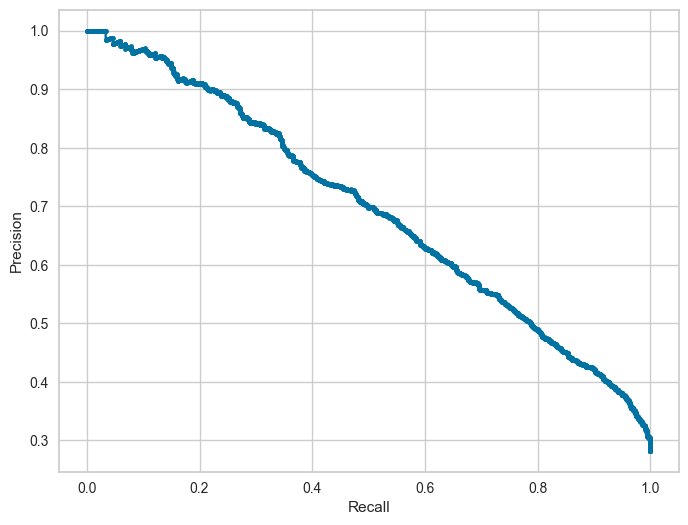

In [ ]:
plot_prc_curve(train_lightgbm_escorado['y'], train_lightgbm_escorado['score_1'], title="Precision-Recall Curve", show_ap=True)


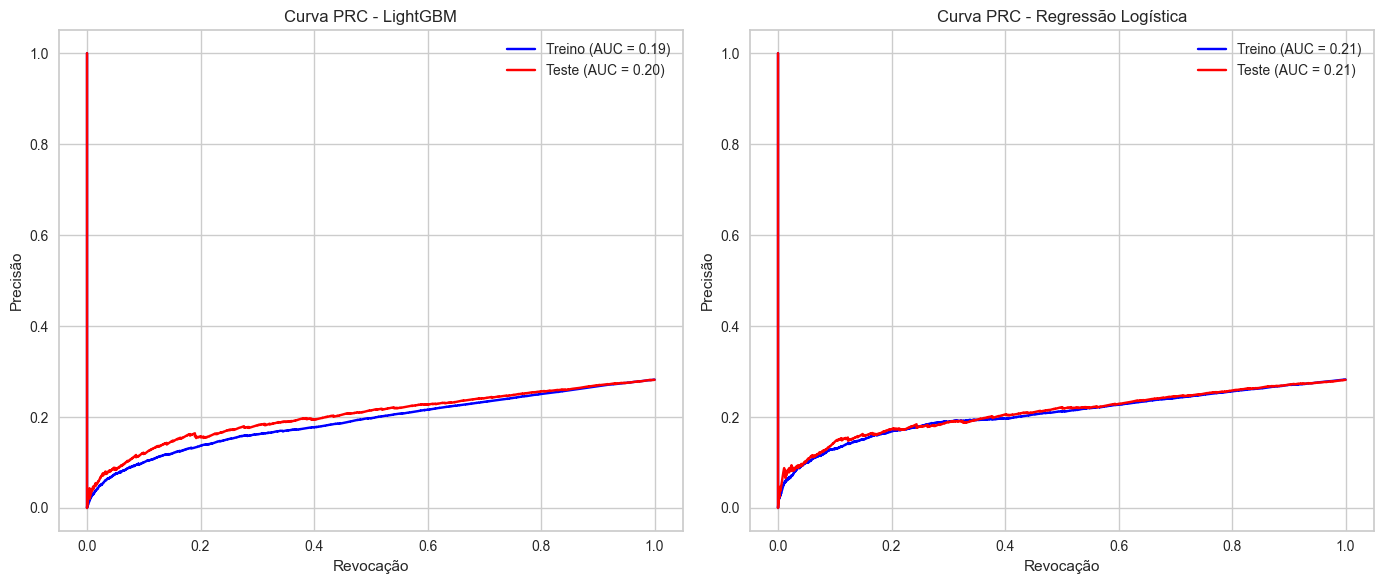

In [11]:
plot_comparacao_prc(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
)